In [4]:
#!pip install pyannote.audio huggingface_hub transformers librosa matplotlib seaborn torch numpy pandas soundfile tensorflow onnxruntime
#pip install spacy --prefer-binary
#pip install librosa pyAudioAnalysis scikit-learn numpy tf_keras keybert opensmile
#!pip install ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [ffmpeg-python]


In [65]:
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.audio import Model, Pipeline
from huggingface_hub import login
from IPython.display import Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import numpy as np
import pandas as pd
import soundfile as sf
import re
import warnings
import tf_keras as keras

import pandas as pd
import spacy
from transformers import pipeline
from keybert import KeyBERT

import opensmile
import os
import librosa
import soundfile as sf

import librosa
from pyAudioAnalysis import ShortTermFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import concurrent.futures
from tqdm import tqdm

from torch.cuda.amp import GradScaler, autocast
import torch
import torchaudio

from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset, DataLoader
import concurrent.futures
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

import random
import torchaudio.transforms as T
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing
import time

import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress PyTorch warnings
torch.set_printoptions(profile="default")

from glob import glob

In [3]:
# Map emotion codes to labels
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
label_map = {label: idx for idx, label in enumerate(sorted(set(emotion_map.values())))}
idx_to_label = {v: k for k, v in label_map.items()}

In [5]:
base_dir = r"home/jupyter/FileLoading/audio_training"

### Load Data

#### Feature Extraction

In [6]:
def get_all_ravdess_audio_paths(base_dir):
    return glob(os.path.join(base_dir, '*.wav'))

In [7]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    f0 = librosa.yin(y, fmin=50, fmax=300)
    pitch_mean = float(np.mean(f0))
    pitch_std = float(np.std(f0))

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    tempo = float(tempo)

    st_feats, _ = ShortTermFeatures.feature_extraction(y, sr, 0.05 * sr, 0.025 * sr)
    energy = float(np.mean(st_feats[1]))  # Energy is index 1

    features = [pitch_mean, pitch_std, tempo, energy]

    if not all(np.isfinite(features)):
        raise ValueError(f"Non-finite values in features from {file_path}")

    return features

In [8]:
def extract_mfcc_torch(file_path, sample_rate=16000, n_mfcc=13, max_len=300):
    waveform, sr = torchaudio.load(file_path)

    # Convert stereo to mono if needed
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)

    mfcc = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
    )(waveform).squeeze(0)
    delta = torchaudio.functional.compute_deltas(mfcc)
    delta2 = torchaudio.functional.compute_deltas(delta)
    mfcc = torch.cat([mfcc, delta, delta2], dim=1)  # Final shape: (n_mfcc*3, time)

    if mfcc.shape[1] < max_len:
        pad = max_len - mfcc.shape[1]
        mfcc = torch.nn.functional.pad(mfcc, (0, pad))
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.T  # shape: (max_len, n_mfcc)

#### Load DataSet

In [9]:
def process_path(path):
    import os  # re-import if needed in subprocess
    filename = os.path.basename(path)
    parts = filename.split('-')
    if len(parts) < 7:
        return None

    emotion_code = parts[2]
    emotion_label = emotion_map.get(emotion_code)
    if not emotion_label:
        return None

    features = extract_features(path)
    if len(features) == 4:
        return (path, emotion_label)
    return None

In [10]:
def load_ravdess_dataset(base_dir):
    X, y = [], []
    audio_paths = get_all_ravdess_audio_paths(base_dir)

    print("🚀 Extracting features in parallel...")
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        results = list(tqdm(executor.map(process_path, audio_paths), total=len(audio_paths), desc="Processing RAVDESS"))

    valid_results = [res for res in results if res is not None]
    if valid_results:
        X, y = zip(*valid_results)
    else:
        X, y = [], []

    return np.array(X), np.array(y)

In [11]:
def extract_example(file_path, label, augment=False, sample_rate=16000, max_len=300):
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    if augment:
        waveform = augment_waveform(waveform, sr)

    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)

    # Compute MFCC and deltas
    mfcc = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=13,
        melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
    )(waveform).squeeze(0)  # (13, T)

    delta = torchaudio.functional.compute_deltas(mfcc)
    delta2 = torchaudio.functional.compute_deltas(delta)
    features = torch.cat([mfcc, delta, delta2], dim=0)  # (39, T)

    # ✅ Pad/truncate **time dimension**
    if features.shape[1] < max_len:
        pad_len = max_len - features.shape[1]
        features = torch.nn.functional.pad(features, (0, pad_len))  # pad last dim (time)
    else:
        features = features[:, :max_len]

    features = features.T  # final shape: (max_len, 39)
    y = label_map[label]
    return torch.tensor(features, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


In [12]:
def augment_waveform(waveform, sample_rate):
    if random.random() < 0.2:
        n_steps = random.uniform(-1, 1)  # softer pitch shift
        waveform = torchaudio.functional.pitch_shift(waveform, sample_rate, n_steps)

    if random.random() < 0.2:
        noise = torch.randn_like(waveform) * 0.002  # less noise
        waveform = waveform + noise

    return waveform

In [13]:
class PreloadedEmotionDataset(Dataset):
    def __init__(self, data):
        self.data = [d for d in data if d is not None]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [14]:
class EmotionLSTM(nn.Module):
    def __init__(self, input_dim=39, hidden_dim=128, num_layers=2, num_classes=8, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [15]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.best_loss = float('inf')
        self.patience = patience
        self.counter = 0
    def check(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

In [16]:
scaler = GradScaler()

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

In [17]:
def evaluate_model(model, dataloader, device, criterion=None, return_loss=False):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)

            if return_loss and criterion is not None:
                loss = criterion(outputs, batch_y)
                total_loss += loss.item()
                count += 1

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())

    labels = [idx_to_label[i] for i in all_labels]
    preds = [idx_to_label[i] for i in all_preds]
    print(classification_report(labels, preds))

    correct = sum(p == t for p, t in zip(all_preds, all_labels))
    accuracy = correct / len(all_labels)

    if return_loss and count > 0:
        return accuracy, total_loss / count
    else:
        return accuracy

#### Simple LSTM

In [18]:
def run_experiment(hidden_dim, num_layers, dropout, lr, batch_size):
    print(f"\n🚀 Training with hidden_dim={hidden_dim}, layers={num_layers}, dropout={dropout}, lr={lr}, batch={batch_size}")

    model = EmotionLSTM(input_dim=39, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=8, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)  # computed earlier
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

    for epoch in range(10):  # Can increase if needed
        print(f"Epoch {epoch+1}/10")
        train_model(model, train_loader, criterion, optimizer, device)

    print("\n✅ Evaluation:")
    evaluate_model(model, test_loader, device)


In [19]:
if __name__ == "__main__":
    import concurrent.futures
    from multiprocessing import cpu_count

    base_dir = os.path.expanduser("~/FileLoading/audio_training")

    print("📂 Loading RAVDESS file paths...")
    file_paths, labels = load_ravdess_dataset(base_dir)

    print("🔀 Splitting dataset in parallel...")
    def split_dataset():
        return train_test_split(
            file_paths, labels, test_size=0.2, random_state=42, stratify=labels
        )

    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(split_dataset)
        with tqdm(total=1, desc="Splitting dataset", unit="task") as pbar:
            while not future.done():
                time.sleep(0.1)
            train_paths, test_paths, train_labels, test_labels = future.result()
            pbar.update(1)

    print("🧪 Extracting training features in parallel...")
    with concurrent.futures.ThreadPoolExecutor() as executor:
        train_data = list(tqdm(
            executor.map(lambda args: extract_example(*args), zip(train_paths, train_labels)),
            total=len(train_paths),
            desc="Training data"
        ))

    print("🧪 Extracting test features in parallel...")
    with concurrent.futures.ThreadPoolExecutor() as executor:
        test_data = list(tqdm(
            executor.map(lambda args: extract_example(*args, augment=False), zip(test_paths, test_labels)),
            total=len(test_paths),
            desc="Testing data"
        ))

    print("📦 Preparing datasets and dataloaders...")
    train_dataset = PreloadedEmotionDataset(train_data)
    test_dataset = PreloadedEmotionDataset(test_data)

    val_size = int(0.2 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    print("⚙️ Running hyperparameter experiments...")
    param_sets = [
        {"hidden_dim": 512, "num_layers": 2, "dropout": 0.3, "lr": 0.0005, "batch_size": 64},#Validation Accuracy: 0.6545 
        {"hidden_dim": 384, "num_layers": 2, "dropout": 0.5, "lr": 0.0005, "batch_size": 64}, # 1st Validation Accuracy: 0.6545
        {"hidden_dim": 512, "num_layers": 2, "dropout": 0.5, "lr": 0.0005, "batch_size": 64},#Validation Accuracy: 0.6361 
        {"hidden_dim": 384, "num_layers": 2, "dropout": 0.3, "lr": 0.0005, "batch_size": 64},#Validation Accuracy: 0.6545 

    ]

    best_acc = 0.0
    best_model_state = None
    best_params = None

    for params in param_sets:
        print(f"\n🚀 Running experiment with: {params}")

        model_params = {
            "hidden_dim": params["hidden_dim"],
            "num_layers": params["num_layers"],
            "dropout": params["dropout"]
        }

        model = EmotionLSTM(input_dim=39, **model_params).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=16, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], num_workers=16, pin_memory=True)

        for epoch in range(30):
            print(f"📅 Epoch {epoch+1}/30")
            train_model(model, train_loader, criterion, optimizer, device)

        val_acc, _ = evaluate_model(model, val_loader, device, criterion=criterion, return_loss=True)
        print(f"📊 Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
            best_params = params
            torch.save({
                "model_state_dict": best_model_state,
                "params": best_params
            }, "emotion_lstm_best.pth")
            print("💾 New best model saved.")


📂 Loading RAVDESS file paths...
🚀 Extracting features in parallel...


Processing RAVDESS: 100%|██████████| 2392/2392 [04:57<00:00,  8.04it/s]


🔀 Splitting dataset in parallel...


Splitting dataset: 100%|██████████| 1/1 [00:00<00:00,  9.91task/s]

🧪 Extracting training features in parallel...



Training data: 100%|██████████| 1913/1913 [00:10<00:00, 174.07it/s]


🧪 Extracting test features in parallel...


Testing data: 100%|██████████| 479/479 [00:02<00:00, 173.95it/s]


📦 Preparing datasets and dataloaders...
⚙️ Running hyperparameter experiments...

🚀 Running experiment with: {'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}
📅 Epoch 1/30
📅 Epoch 2/30
📅 Epoch 3/30
📅 Epoch 4/30
📅 Epoch 5/30
📅 Epoch 6/30
📅 Epoch 7/30
📅 Epoch 8/30
📅 Epoch 9/30
📅 Epoch 10/30
📅 Epoch 11/30
📅 Epoch 12/30
📅 Epoch 13/30
📅 Epoch 14/30
📅 Epoch 15/30
📅 Epoch 16/30
📅 Epoch 17/30
📅 Epoch 18/30
📅 Epoch 19/30
📅 Epoch 20/30
📅 Epoch 21/30
📅 Epoch 22/30
📅 Epoch 23/30
📅 Epoch 24/30
📅 Epoch 25/30
📅 Epoch 26/30
📅 Epoch 27/30
📅 Epoch 28/30
📅 Epoch 29/30
📅 Epoch 30/30
              precision    recall  f1-score   support

       angry       0.90      0.82      0.86        56
        calm       0.55      0.90      0.68        60
     disgust       0.64      0.95      0.77        19
     fearful       0.59      0.63      0.61        52
       happy       0.71      0.64      0.67        61
     neutral       0.38      0.69      0.49        26
         sad    

### DEPLOYMENT

In [ ]:
#!pip install --force-reinstall moviepy
#!pip install datasets

### Diarization and Transcript

In [280]:
from pyannote.audio import Pipeline
from transformers import pipeline as hf_pipeline
import torch
import torchaudio
import os
import pandas as pd
import ffmpeg
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import tempfile
from datasets import Dataset
from dotenv import load_dotenv

In [ ]:
audio_path = os.path.expanduser(r"/home/jupyter/FileLoading/pharmacy_audio.mp3")
#audio_path = os.path.expanduser(r"/home/jupyter/FileLoading/insurance_audio.mp3")
#audio_path = os.path.expanduser(r"/home/jupyter/FileLoading/loan_audio.mp3")
torchaudio.set_audio_backend("sox_io")
waveform, sample_rate = torchaudio.load(audio_path)
load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("<token>")

In [353]:
# 2. Resample to mono 16kHz
if sample_rate != 16000 or waveform.shape[0] != 1:
    waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)
    waveform = waveform.mean(dim=0, keepdim=True)
    sample_rate = 16000

In [354]:
# 3. Save to temp WAV for diarization
with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_wav:
    torchaudio.save(temp_wav.name, waveform, sample_rate)
    wav_path = temp_wav.name

In [ ]:
from pyannote.audio import Pipeline
HUGGINGFACE_TOKEN = "<token>"
print("🔍 Loading diarization pipeline...")
pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization",
    use_auth_token=HUGGINGFACE_TOKEN
)
pipeline.to(torch.device("cuda"))
diarization = pipeline(wav_path)

🔍 Loading diarization pipeline...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1+cu126. Bad things might happen unless you revert torch to 1.x.


In [356]:
# 6. Load Whisper transcription model
print("🧠 Loading Whisper LLM (large)...")
transcriber = hf_pipeline("automatic-speech-recognition", model="openai/whisper-large-v3", device=0)


🧠 Loading Whisper LLM (large)...


Device set to use cuda:0


In [357]:
# 7. Extract speaker segments
def segment_audio(diarization, audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    segments = []
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        start = int(turn.start * sample_rate)
        end = int(turn.end * sample_rate)
        segments.append((speaker, turn.start, turn.end, waveform[:, start:end]))
    return segments, sample_rate

In [358]:
from transformers import pipeline

asr = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-large-v3",
    device=0,
    return_timestamps=False,
    generate_kwargs={"language": "en"}  # ✅ specify language here
)

Device set to use cuda:0


In [359]:

segments, sr = segment_audio(diarization, wav_path)

# 8. Transcribe in parallel
def transcribe_segment(segment):
    speaker, start, end, audio = segment
    audio = audio.squeeze().numpy()
    result = asr({"raw": audio, "sampling_rate": 16000})
    text = result["text"].strip()
    return {"Speaker": speaker, "Timestamp": f"{start:.2f}s - {end:.2f}s", "Text": text}

In [360]:
print("✍️ Transcribing segments (parallelized)...")
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(transcribe_segment, segments), total=len(segments)))

# 9. Convert to DataFrame
df = pd.DataFrame(results, columns=["Speaker", "Timestamp", "Text"])
# Mapping Speaker Names
speaker_mapping = {
    "SPEAKER_00": "Customer",
    "SPEAKER_01": "Representative"
}
# Apply Mapping
df["Speaker"] = df["Speaker"].map(speaker_mapping)

df.head()

✍️ Transcribing segments (parallelized)...


100%|██████████| 18/18 [00:24<00:00,  1.37s/it]


,Speaker,Timestamp,Text
0,Customer,0.62s - 3.39s,"Hi, thank you for calling Contoso Pharmacy. Wh..."
1,Representative,4.54s - 16.28s,Good afternoon. My name is Mary. I'm calling b...
2,Customer,17.55s - 21.39s,"I understand your frustration, Mary. Can you t..."
3,Representative,22.49s - 27.30s,"Yes, I'm trying to get a refill of my prescrip..."
4,Customer,28.99s - 32.72s,"Okay, certainly happy to check that for you. O..."


### Sensitivity Analysis

In [361]:
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [362]:
# Apply sentiment analysis
df["Sentiment"] = df["Text"].apply(lambda x: sentiment_pipeline(x)[0]['label'])
df.head()

,Speaker,Timestamp,Text,Sentiment
0,Customer,0.62s - 3.39s,"Hi, thank you for calling Contoso Pharmacy. Wh...",positive
1,Representative,4.54s - 16.28s,Good afternoon. My name is Mary. I'm calling b...,neutral
2,Customer,17.55s - 21.39s,"I understand your frustration, Mary. Can you t...",neutral
3,Representative,22.49s - 27.30s,"Yes, I'm trying to get a refill of my prescrip...",neutral
4,Customer,28.99s - 32.72s,"Okay, certainly happy to check that for you. O...",positive


In [363]:
# Count occurrences of each sentiment category
sentiment_counts = df["Sentiment"].value_counts()

# Ensure "positive" and "negative" exist; otherwise, set them to 0
sentiment_counts = sentiment_counts.reindex(["positive", "negative"], fill_value=0)


### Emotions Integration

In [364]:
import torch.nn as nn

# 🧠 Define the exact architecture used in training
class EmotionLSTM(nn.Module):
    def __init__(self, input_dim=39, hidden_dim=512, num_layers=2, num_classes=8, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])  # shape: (batch, num_classes)



In [365]:
# 🔄 Load checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("emotion_lstm_best.pth", map_location=device)
params = checkpoint["params"]

# 📦 Rebuild the model using best hyperparameters
model = EmotionLSTM(
    input_dim=39,
    hidden_dim=params["hidden_dim"],
    num_layers=params["num_layers"],
    dropout=params["dropout"],
    num_classes=8  # Based on your dataset
).to(device)

# 🧠 Load weights
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ Emotion model loaded and ready.")

✅ Emotion model loaded and ready.


In [366]:
import torchaudio.transforms as T

mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)

def extract_features(audio_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Move transform to same device as input audio
    mfcc_transform = T.MFCC(
        sample_rate=16000,
        n_mfcc=13,
        melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
    ).to(device)

    with torch.no_grad():
        mfcc = mfcc_transform(audio_tensor).transpose(1, 2)  # (1, time, 13)
        delta = torchaudio.functional.compute_deltas(mfcc)
        delta2 = torchaudio.functional.compute_deltas(delta)
        features = torch.cat([mfcc, delta, delta2], dim=-1)  # shape: (1, time, 39)
    return features

In [367]:
def transcribe_segment_with_emotion(segment):
    speaker, start, end, audio = segment
    speaker_mapping = {
    "SPEAKER_00": "Customer",
    "SPEAKER_01": "Representative"
    }
    speaker_name = speaker_mapping.get(speaker, speaker)
    audio = audio.to("cuda")
    audio_np = audio.squeeze().cpu().numpy()
    
    # Transcription
    result = asr({"raw": audio_np, "sampling_rate": 16000})
    text = result["text"].strip()
    sentiment = sentiment_pipeline(text)[0]["label"].lower()

    # Emotion prediction
    features = extract_features(audio).to(device)
    with torch.no_grad():
        logits = model(features.to(device))
        predicted_idx = torch.argmax(logits, dim=1).item()

    emotion_label = idx_to_label[predicted_idx]
    

    return {
        "Speaker": speaker_name,
        "Timestamp": f"{start:.2f}s - {end:.2f}s",
        "Text": text,
        "Sentiment": sentiment,
        "Emotion": emotion_label
    }


In [368]:
#3. Emotion Prediction Function
emotion_labels = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
label_to_idx = {label: i for i, label in enumerate(emotion_labels)}
idx_to_label = {i: label for label, i in label_to_idx.items()}

In [369]:
print("🧠 Running transcription + emotion inference...")
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(transcribe_segment_with_emotion, segments), total=len(segments)))


🧠 Running transcription + emotion inference...


100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


In [370]:
df = pd.DataFrame(results, columns=["Speaker", "Timestamp", "Text", 'Sentiment',"Sentiment Score","Exchange", "Emotion"])
df.head()

,Speaker,Timestamp,Text,Sentiment,Sentiment Score,Exchange,Emotion
0,Customer,0.62s - 3.39s,"Hi, thank you for calling Contoso Pharmacy. Wh...",positive,NaN,NaN,neutral
1,Representative,4.54s - 16.28s,Good afternoon. My name is Mary. I'm calling b...,neutral,NaN,NaN,neutral
2,Customer,17.55s - 21.39s,"I understand your frustration, Mary. Can you t...",neutral,NaN,NaN,neutral
3,Representative,22.49s - 27.30s,"Yes, I'm trying to get a refill of my prescrip...",neutral,NaN,NaN,angry
4,Customer,28.99s - 32.72s,"Okay, certainly happy to check that for you. O...",positive,NaN,NaN,neutral


In [371]:
# Map sentiment to numerical values
sentiment_mapping = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

df["Sentiment Score"] = df["Sentiment"].map(sentiment_mapping)

# Assign exchange numbers for X-axis
df["Exchange"] = range(1, len(df) + 1)

In [372]:
df[~(df['Emotion']=='happy') & ~(df['Emotion']=='neutral')]

,Speaker,Timestamp,Text,Sentiment,Sentiment Score,Exchange,Emotion
3,Representative,22.49s - 27.30s,"Yes, I'm trying to get a refill of my prescrip...",neutral,0,4,angry


#### Visualization

In [373]:
def extract_midpoint(timestamp):
    match = re.match(r"(\d+\.?\d*)s\s*-\s*(\d+\.?\d*)s", timestamp)
    if match:
        start, end = map(float, match.groups())
        return (start + end) / 2
    return None

df["Time"] = df["Timestamp"].apply(extract_midpoint)

In [374]:
emotion_styles = {
    "neutral":   {"Customer": {"symbol": "○", "color": "gray"},         "Representative": {"symbol": "●", "color": "gray"}},
    "calm": {"Customer": {"symbol": "☁",  "color": "lightblue"}, "Representative": {"symbol": "☀",  "color": "lightblue"}},
    "happy":     {"Customer": {"symbol": "☺", "color": "gold"},         "Representative": {"symbol": "☻", "color": "gold"}},
    "sad":       {"Customer": {"symbol": "😞", "color": "steelblue"},   "Representative": {"symbol": "☹", "color": "steelblue"}},
    "angry":     {"Customer": {"symbol": "😠", "color": "red"},          "Representative": {"symbol": "😡", "color": "red"}},
    "fearful":   {"Customer": {"symbol": "⚠️", "color": "purple"},       "Representative": {"symbol": "!", "color": "purple"}},
    "disgust":   {"Customer": {"symbol": "😷", "color": "green"},        "Representative": {"symbol": "☠️", "color": "green"}},
    "surprised": {"Customer": {"symbol": "😲", "color": "turquoise"},    "Representative": {"symbol": "😧", "color": "turquoise"}}
}
speaker_colors = {
    "Customer": "blue",
    "Representative": "green"
}


<IPython.core.display.Javascript object>

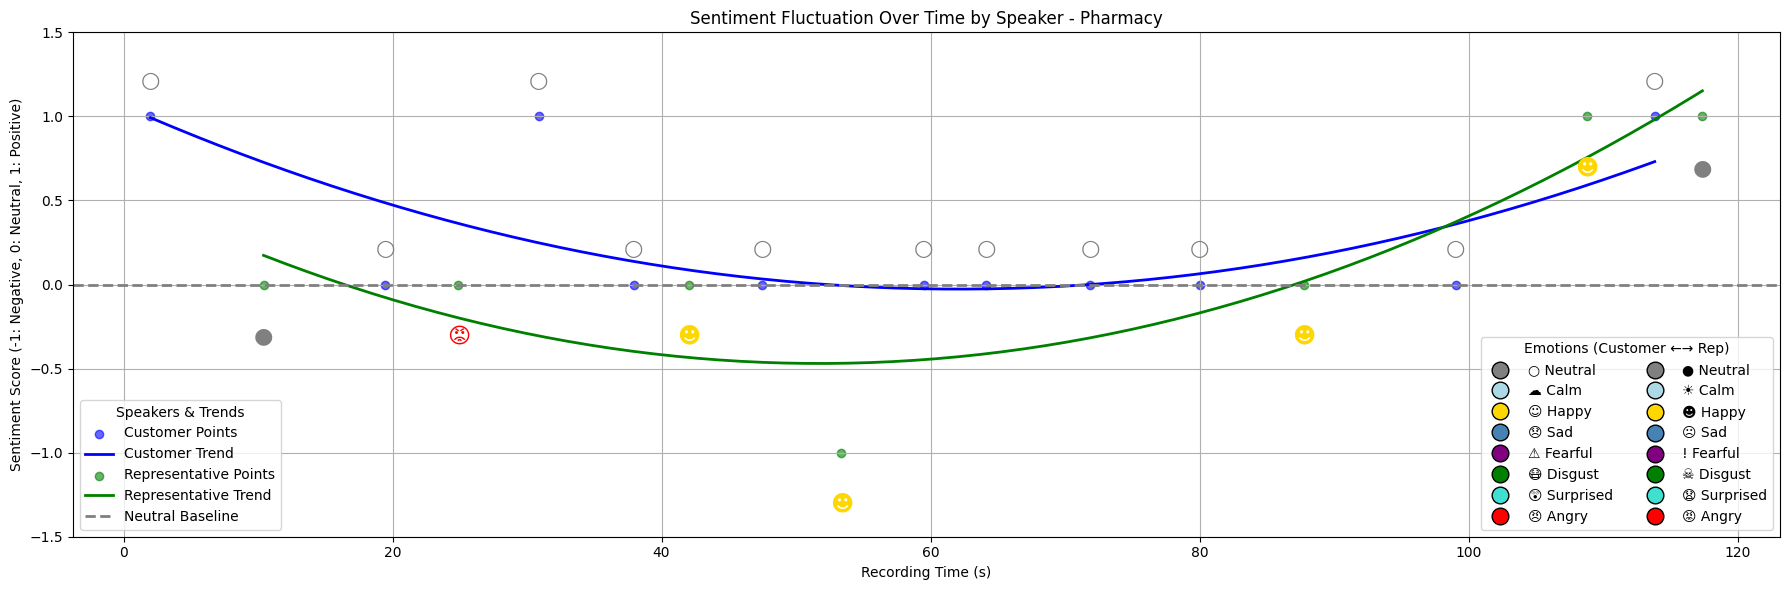

In [377]:
plt.figure(figsize=(18, 6))

for speaker, color in speaker_colors.items():
    speaker_df = df[df["Speaker"] == speaker].dropna(subset=["Time", "Sentiment Score"])

    speaker_df = speaker_df.copy()
    speaker_df["Time"] = pd.to_numeric(speaker_df["Time"], errors="coerce")
    speaker_df["Sentiment Score"] = pd.to_numeric(speaker_df["Sentiment Score"], errors="coerce")
    speaker_df.dropna(subset=["Time", "Sentiment Score"], inplace=True)

    plt.scatter(speaker_df["Time"], speaker_df["Sentiment Score"], color=color, alpha=0.6, label=f"{speaker} Points")

    for _, row in speaker_df.iterrows():
        style = emotion_styles.get(row["Emotion"], {}).get(row["Speaker"], {"symbol": "?", "color": "black"})
        y_offset = 0.15 if row["Speaker"] == "Customer" else -0.25
        va = "bottom" if row["Speaker"] == "Customer" else "top"

        plt.text(row["Time"], row["Sentiment Score"] + y_offset,
                 style["symbol"], fontsize=16, ha="center", va=va, color=style["color"])

    if len(speaker_df) >= 3:
        z = np.polyfit(speaker_df["Time"], speaker_df["Sentiment Score"], 2)
        p = np.poly1d(z)
        time_range = np.linspace(speaker_df["Time"].min(), speaker_df["Time"].max(), 200)
        plt.plot(time_range, p(time_range), color=color, linewidth=2, label=f"{speaker} Trend")

# Add neutral baseline
plt.axhline(y=0, color="gray", linestyle="dashed", linewidth=2, label="Neutral Baseline")

# Labels and styling
plt.xlabel("Recording Time (s)")
plt.ylabel("Sentiment Score (-1: Negative, 0: Neutral, 1: Positive)")
plt.title("Sentiment Fluctuation Over Time by Speaker - Pharmacy")
plt.ylim(-1.5, 1.5)
plt.grid()

# First legend: speakers
first_legend = plt.legend(loc="lower left", title="Speakers & Trends")
plt.gca().add_artist(first_legend)

# Build dual-column emoji legend (without repeated "Customer"/"Rep")
emotion_order = ["neutral", "calm", "happy", "sad", "fearful", "disgust", "surprised", "angry"]

col_a = []
col_b = []
labels_a = []
labels_b = []

for emotion in emotion_order:
    customer = emotion_styles[emotion]["Customer"]
    rep = emotion_styles[emotion]["Representative"]

    col_a.append(Line2D([0], [0], marker='o', color='none',
                        markerfacecolor=customer["color"], markersize=12, linestyle='None'))
    labels_a.append(f"{customer['symbol']} {emotion.capitalize()}")

    col_b.append(Line2D([0], [0], marker='o', color='none',
                        markerfacecolor=rep["color"], markersize=12, linestyle='None'))
    labels_b.append(f"{rep['symbol']} {emotion.capitalize()}")

# Combine and add legend
plt.legend(handles=col_a + col_b,
           labels=labels_a + labels_b,
           loc="lower right",
           title="Emotions (Customer ←→ Rep)",
           ncol=2,
           columnspacing=2.0,
           handletextpad=1.0)

plt.tight_layout()
plt.savefig("sentiment_over_time_by_speaker.png", bbox_inches='tight')
plt.close()

Image("sentiment_over_time_by_speaker.png")

In [376]:
plt.figure(figsize=(18, 6))

for speaker, color in speaker_colors.items():
    speaker_df = df[df["Speaker"] == speaker].dropna(subset=["Time", "Sentiment Score"])

    speaker_df = speaker_df.copy()
    speaker_df["Time"] = pd.to_numeric(speaker_df["Time"], errors="coerce")
    speaker_df["Sentiment Score"] = pd.to_numeric(speaker_df["Sentiment Score"], errors="coerce")
    speaker_df.dropna(subset=["Time", "Sentiment Score"], inplace=True)

    plt.scatter(speaker_df["Time"], speaker_df["Sentiment Score"], color=color, alpha=0.6, label=f"{speaker} Points")

    for _, row in speaker_df.iterrows():
        style = emotion_styles.get(row["Emotion"], {"emoji": "❓", "color": "black"})
        y_offset = 0.15 if row["Speaker"] == "Customer" else -0.25
        va = "bottom" if row["Speaker"] == "Customer" else "top"
        plt.text(row["Time"], row["Sentiment Score"] + y_offset,
                 style["emoji"], fontsize=15, ha="center", va=va, color=style["color"])

    if len(speaker_df) >= 3:
        z = np.polyfit(speaker_df["Time"], speaker_df["Sentiment Score"], 2)
        p = np.poly1d(z)
        time_range = np.linspace(speaker_df["Time"].min(), speaker_df["Time"].max(), 200)
        plt.plot(time_range, p(time_range), color=color, linewidth=2, label=f"{speaker} Trend")

plt.axhline(y=0, color="gray", linestyle="dashed", linewidth=2, label="Neutral Baseline")

plt.xlabel("Recording Time (s)")
plt.ylabel("Sentiment Score (-1: Negative, 0: Neutral, 1: Positive)")
plt.title("Sentiment Fluctuation Over Time by Speaker - Loan")
plt.ylim(-1.5, 1.5)
plt.grid()

first_legend = plt.legend(loc="lower left", title="Speakers & Trends")
plt.gca().add_artist(first_legend)

emoji_legend_elements = [
    Line2D([0], [0],
           marker='o',
           color='none',
           label=f"{v['emoji']} {k.capitalize()}",
           markerfacecolor=v["color"],
           markersize=12,
           linestyle='None')
    for k, v in emotion_styles.items()
]
plt.legend(handles=emoji_legend_elements, loc="lower right", title="Emotions")

plt.tight_layout()
plt.savefig("sentiment_over_time_by_speaker.png", bbox_inches='tight')
plt.close()

Image("sentiment_over_time_by_speaker.png")

<IPython.core.display.Javascript object>

KeyError: 'emoji'